In [5]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch the historical market data
str = "AAPL"
data = yf.download(str, start='2010-01-01', end='2023-09-01')
data = data.copy()



[*********************100%%**********************]  1 of 1 completed


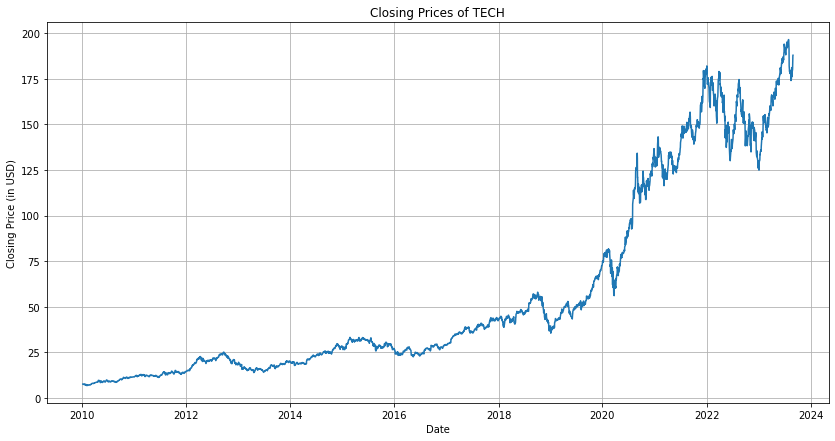

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(data["Close"])

plt.title('Closing Prices of AAPL')
plt.xlabel('Date')
plt.ylabel('Closing Price (in USD)')
plt.grid(True)
plt.show()

In [146]:
# Create a new column for 'Tomorrow' to be used as a learning model 
# Feature engineering
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.dropna()

data

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
2010-01-04,17.264999,17.434999,17.067499,17.170000,14.837848,454400,17.022499,0
2010-01-05,17.122499,17.247499,16.897499,17.022499,14.710379,282000,16.977501,0
2010-01-06,17.100000,17.115000,16.947500,16.977501,14.671498,402800,17.017500,1
2010-01-07,17.007500,17.202499,16.892500,17.017500,14.706064,346400,16.985001,0
2010-01-08,16.969999,17.075001,16.797501,16.985001,14.677975,455200,16.875000,0
...,...,...,...,...,...,...,...,...
2023-08-24,78.540001,79.589996,78.440002,78.790001,78.790001,427500,80.160004,1
2023-08-25,78.790001,80.800003,78.790001,80.160004,80.160004,1020300,78.260002,0
2023-08-28,79.000000,79.529999,77.209999,78.260002,78.260002,1252500,80.279999,1


In [147]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-500]
test = data.iloc[-500:]

predictors= ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [148]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])


In [149]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

In [150]:
precision_score(test["Target"], preds)


0.48148148148148145

In [151]:
combined = pd.concat([test["Target"], preds], axis = 1)

<AxesSubplot:xlabel='Date'>

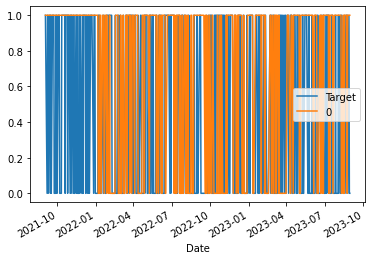

In [152]:
combined.plot()

In [153]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [154]:
def backtest(data, model, predictors, start = 500, step = 125):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [155]:
predictions = backtest(data, model, predictors)

In [156]:
predictions["Predictions"].value_counts()


Predictions
0    1486
1    1452
Name: count, dtype: int64

In [157]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5268595041322314

In [158]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data.loc[:, ratio_column] = data["Close"]/rolling_averages["Close"]
    #ratios between closes in the last x amount of time 
    trend_column = f"Trend_{horizon}"
    data.loc[:, trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]
      
    

In [159]:
data = data.dropna()

In [160]:
data

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2013-12-23,23.192499,23.487499,22.997499,23.254999,21.456551,534800,23.375000,1,1.002695,2.0,1.014196,3.0,1.082163,31.0,1.256218,120.0,1.337324,507.0
2013-12-24,23.295000,23.467501,23.207500,23.375000,21.567270,340800,23.450001,1,1.002573,2.0,1.008978,4.0,1.084920,32.0,1.261007,120.0,1.343734,508.0
2013-12-26,23.459999,23.492500,23.290001,23.450001,21.636465,471200,23.547501,1,1.001602,2.0,1.009014,4.0,1.085889,32.0,1.263319,121.0,1.347544,509.0
2013-12-27,23.455000,23.592501,23.370001,23.547501,21.726431,523600,23.575001,1,1.002075,2.0,1.008393,5.0,1.087546,33.0,1.266808,122.0,1.352639,509.0
2013-12-30,23.477501,23.677500,23.427500,23.575001,21.751799,445600,23.667500,1,1.000584,2.0,1.005738,5.0,1.085920,34.0,1.266587,122.0,1.353706,510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-24,78.540001,79.589996,78.440002,78.790001,78.790001,427500,80.160004,1,1.000699,2.0,1.003362,3.0,0.968610,24.0,0.990737,113.0,0.944783,500.0
2023-08-25,78.790001,80.800003,78.790001,80.160004,80.160004,1020300,78.260002,0,1.008619,2.0,1.015841,4.0,0.985782,25.0,1.008194,114.0,0.960834,500.0
2023-08-28,79.000000,79.529999,77.209999,78.260002,78.260002,1252500,80.279999,1,0.988007,1.0,0.992820,3.0,0.963093,25.0,0.984549,114.0,0.937709,500.0


In [161]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [162]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] 
    #set a custom threshold, so it will only decide to trade when it is confident the stock will go up
    preds[preds>=.6] = 1
    preds[preds<.6]=0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [163]:
predictions = backtest(data, model, new_predictors)

In [164]:
predictions["Predictions"].value_counts()

Predictions
0.0    1535
1.0     403
Name: count, dtype: int64

In [165]:
precision_score(predictions["Target"], predictions["Predictions"])

0.543424317617866

In [166]:
data.to_csv(str+".csv")